# Planet: Understanding the Amazon deforestation from Space challenge

Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

The whole code including the `data_helper.py` and `keras_helper.py` files are available on github [here](https://github.com/EKami/planet-amazon-deforestation) and the notebook can be found on the same github [here](https://github.com/EKami/planet-amazon-deforestation/blob/master/notebooks/amazon_forest_notebook.ipynb)

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')
sys.path.append('../tests')

## Import required modules

In [2]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.callbacks import ModelCheckpoint, CSVLogger

import data_helper
from data_helper import AmazonPreprocessor
from keras_helper import AmazonKerasClassifier, Fbeta
from kaggle_data.downloader import KaggleDataDownloader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [3]:
tf.__version__

'1.2.1'

## Download the competition files
Download the dataset files and extract them automatically with the help of [Kaggle data downloader](https://github.com/EKami/kaggle-data-downloader)

In [4]:
competition_name = "planet-understanding-the-amazon-from-space"

train, train_u = "train-jpg.tar.7z", "train-jpg.tar"
test, test_u = "test-jpg.tar.7z", "test-jpg.tar"
test_additional, test_additional_u = "test-jpg-additional.tar.7z", "test-jpg-additional.tar"
test_labels = "train_v2.csv.zip"
destination_path = "../input/"
is_datasets_present = False

# If the folders already exists then the files may already be extracted
# This is a bit hacky but it's sufficient for our needs
datasets_path = data_helper.get_jpeg_data_files_paths()
for dir_path in datasets_path:
    if os.path.exists(dir_path):
        is_datasets_present = True

if not is_datasets_present:
    # Put your Kaggle user name and password in a $KAGGLE_USER and $KAGGLE_PASSWD env vars respectively
    downloader = KaggleDataDownloader(os.getenv("KAGGLE_USER"), os.getenv("KAGGLE_PASSWD"), competition_name)
    
    train_output_path = downloader.download_dataset(train, destination_path)
    downloader.decompress(train_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + train_u, destination_path) # Extract the content of the previous tar file
    os.remove(train_output_path) # Removes the 7z file
    os.remove(destination_path + train_u) # Removes the tar file
    
    test_output_path = downloader.download_dataset(test, destination_path)
    downloader.decompress(test_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + test_u, destination_path) # Extract the content of the previous tar file
    os.remove(test_output_path) # Removes the 7z file
    os.remove(destination_path + test_u) # Removes the tar file
    
    test_add_output_path = downloader.download_dataset(test_additional, destination_path)
    downloader.decompress(test_add_output_path, destination_path) # Outputs a tar file
    downloader.decompress(destination_path + test_additional_u, destination_path) # Extract the content of the previous tar file
    os.remove(test_add_output_path) # Removes the 7z file
    os.remove(destination_path + test_additional_u) # Removes the tar file
    
    test_labels_output_path = downloader.download_dataset(test_labels, destination_path)
    downloader.decompress(test_labels_output_path, destination_path) # Outputs a csv file
    os.remove(test_labels_output_path) # Removes the zip file
else:
    print("All datasets are present.")

All datasets are present.


## Inspect image labels
Visualize what the training set looks like

In [5]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [6]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'cultivation', 'road', 'primary', 'bare_ground', 'clear', 'habitation', 'slash_burn', 'agriculture', 'blooming', 'artisinal_mine', 'water', 'selective_logging', 'blow_down', 'partly_cloudy', 'cloudy', 'haze', 'conventional_mine'}


### Repartition of each labels

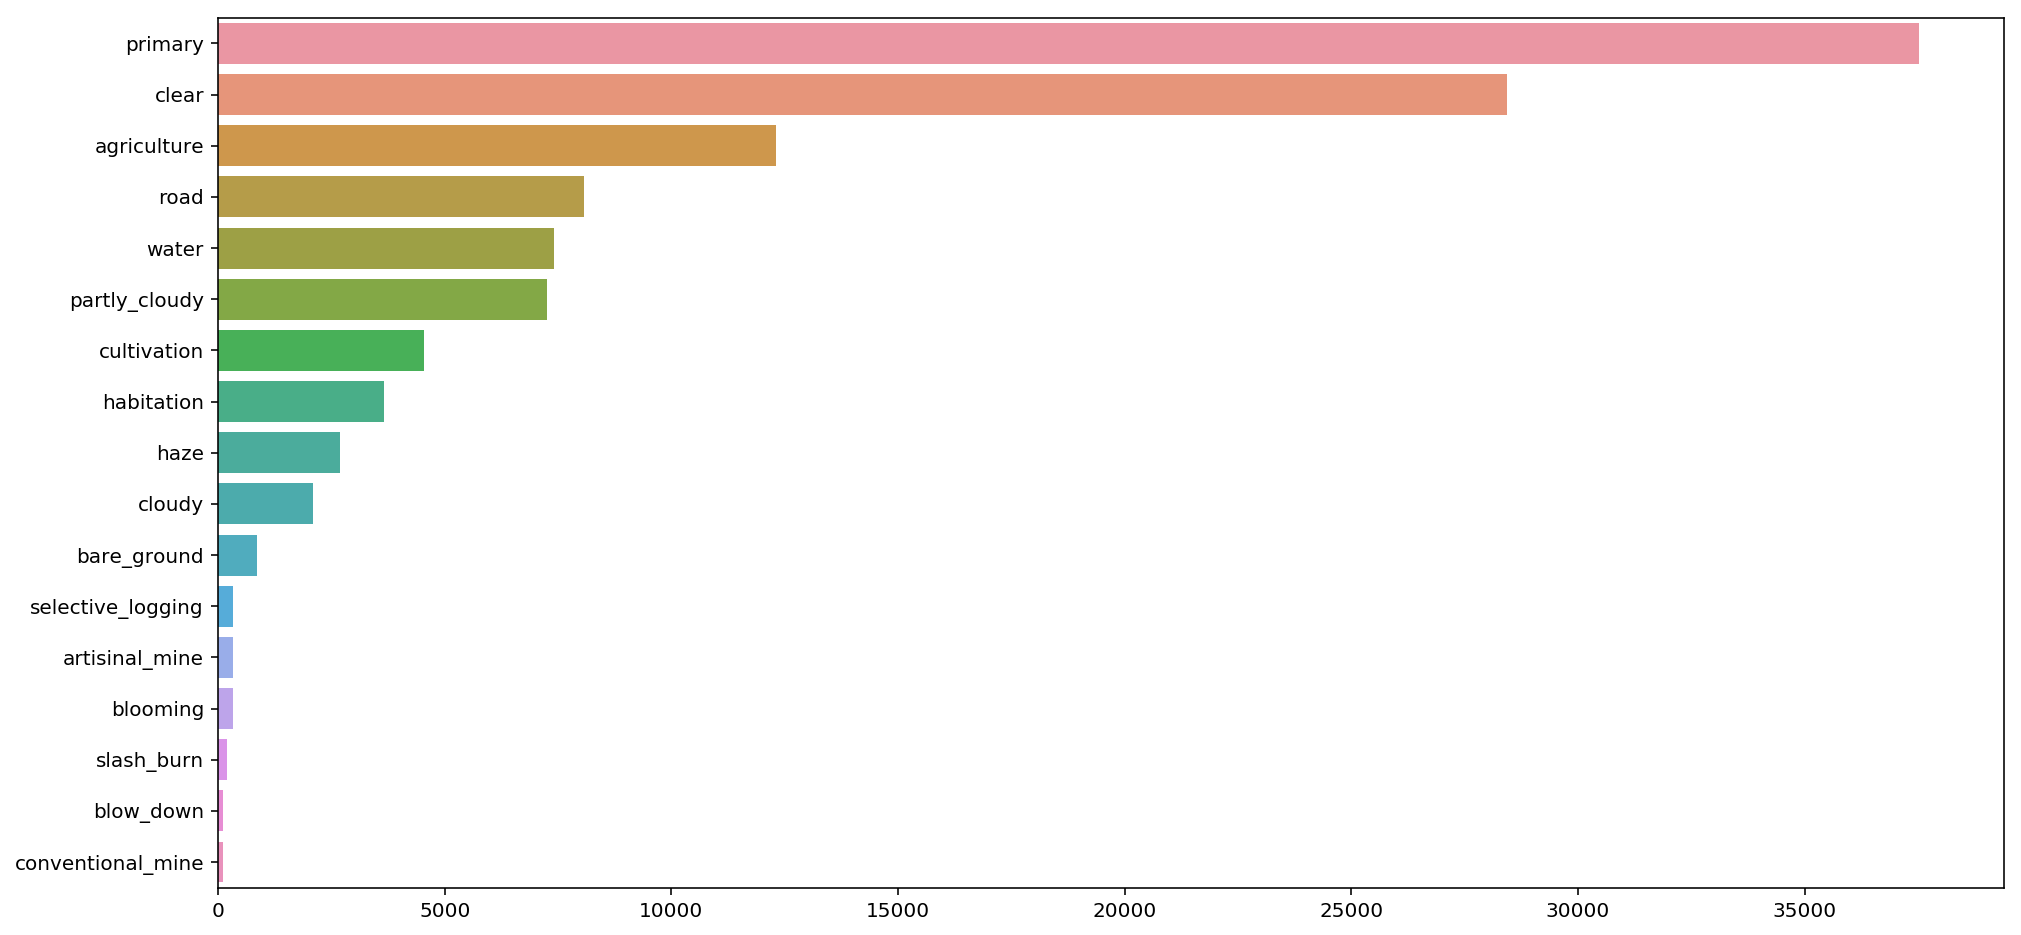

In [7]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

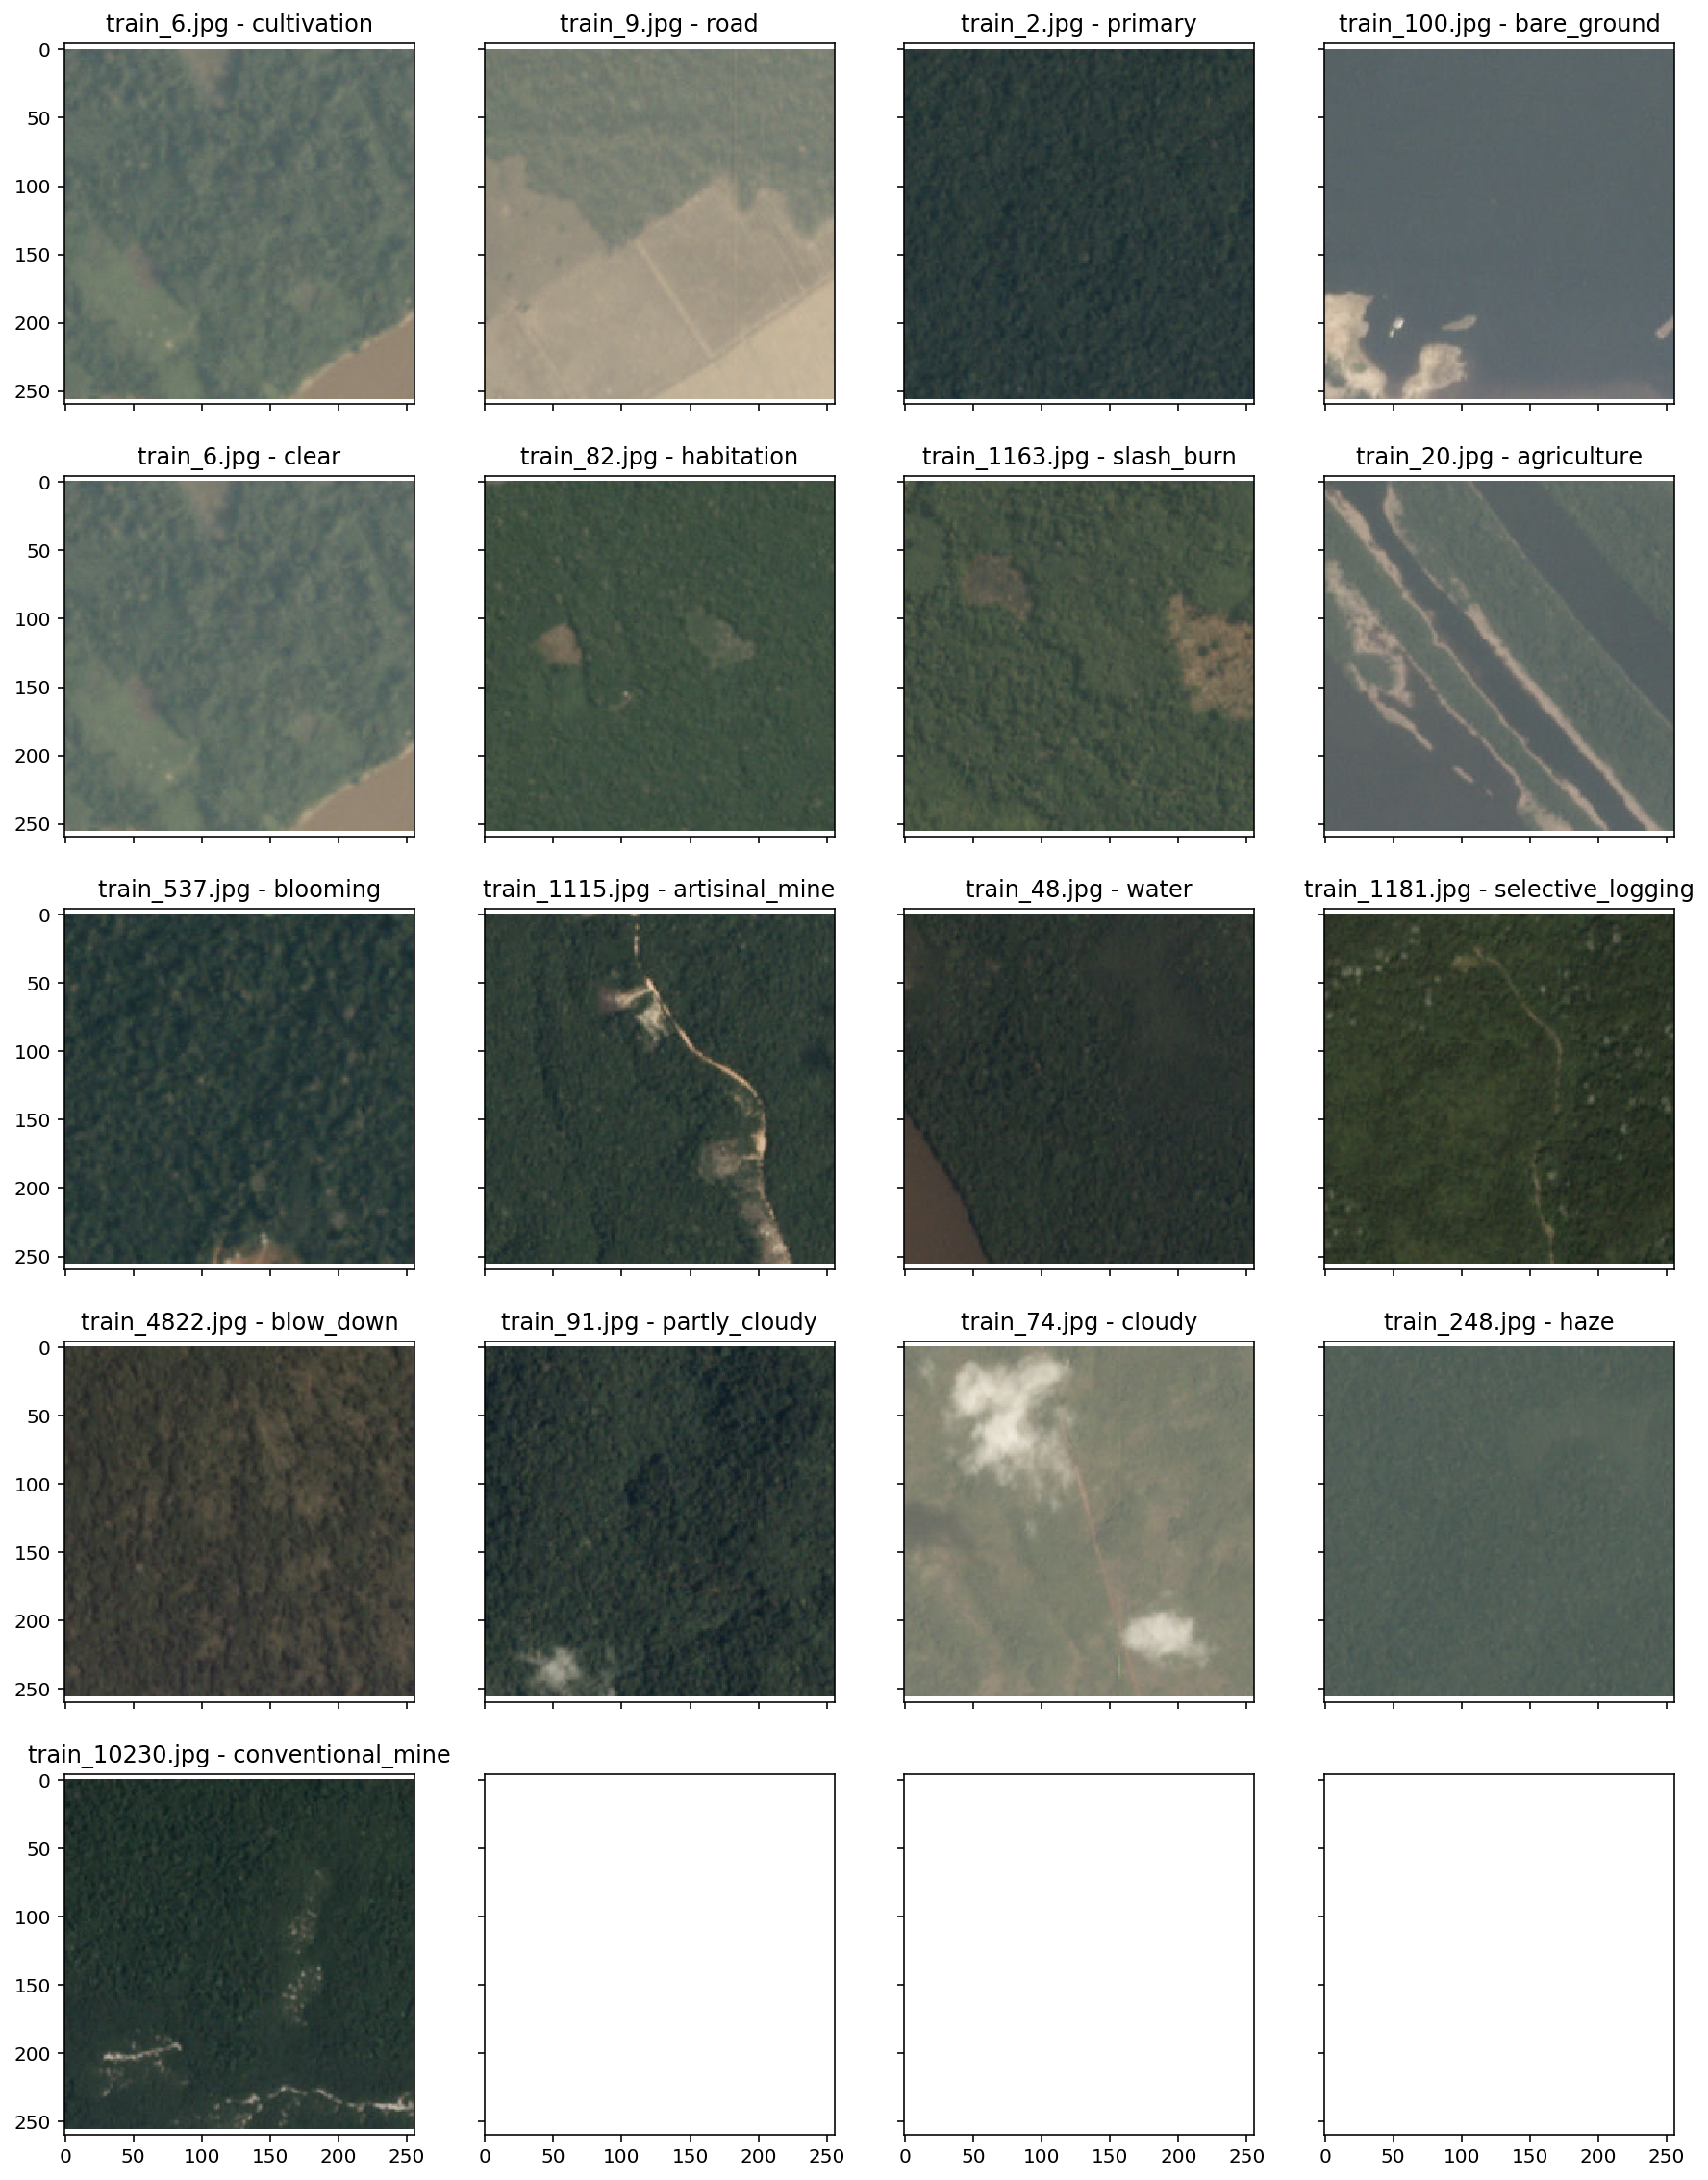

In [8]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Image resize & validation split
Define the dimensions of the image data trained by the network. Recommended resized images could be 32x32, 64x64, or 128x128 to speedup the training. 

You could also use `None` to use full sized images.

Be careful, the higher the `validation_split_size` the more RAM you will consume.

In [9]:
image_size = 64
img_resize = (image_size, image_size) # The resize size of each image ex: (64, 64) or None to use the default image size
validation_split_size = 0.1

# Data preprocessing
Due to the hudge amount of memory the preprocessed images can take, we will create a dedicated `AmazonPreprocessor` class which job is to preprocess the data right in time at specific steps (training/inference) so that our RAM don't get completely filled by the preprocessed images. 

The only exception to this being the validation dataset as we need to use it as-is for f2 score calculation as well as when we calculate the validation accuracy of each batch.

In [10]:
preprocessor = AmazonPreprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_jpeg_additional, 
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 4048/4048 [00:00<00:00, 176113.17it/s]

Transforming val dataset...



100%|██████████| 4048/4048 [00:02<00:00, 1818.79it/s]


Done. Size consumed by validation matrices 189.75 mb


In [11]:
print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val lenght: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/X_test_filename length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.X_test_filename)))
preprocessor.y_map

X_train/y_train length: 36431/36431
X_val/y_val lenght: 4048/4048
X_test/X_test_filename length: 61191/61191


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [12]:
from PIL import Image
preprocessor.train_cursor = 0
preprocessor.test_cursor = 0

#TODO: add some randomization things here to help our model be more general
def get_train_batch(self, batch_size):
    """
    Get the next batch_features and batch_labels. Implement a 'cursor' that moves through 
    @return Tuple<features, labels>
    """
    start_offset = self.train_cursor
    end_offset = start_offset + batch_size - 1
    self.train_cursor += batch_size

#     print('Getting training batch: {}, {}'.format(start_offset, end_offset))

    batch_features = np.zeros((batch_size, *self.img_resize, 3))
    batch_labels = np.zeros((batch_size, len(self.y_train[0])))

    for idx in range(0, batch_size):
        # Maybe shuffle the index?
        img = Image.open(self.X_train[start_offset + idx])
        img.thumbnail(self.img_resize)

        # Augment the image `img` here

        # Convert to RGB and normalize
        img_array = np.asarray(img.convert("RGB"), dtype=np.float32) / 255
        batch_features[idx] = img_array
        batch_labels[idx] = self.y_train[start_offset + idx]

    return (batch_features, batch_labels)

In [13]:
def get_test_batch(self, batch_size):
    start_offset = self.test_cursor
    end_offset = start_offset + batch_size - 1
    self.test_cursor += batch_size
    
#     print('Getting test batch: {}, {}'.format(start_offset, end_offset))
    
    img_arrays = np.zeros((batch_size, *self.img_resize, 3))
    
    for idx in range(0, batch_size):
        img = Image.open(self.X_test_filename[start_offset + idx])
        img.thumbnail(self.img_resize)

        # Convert to RGB and normalize
        img_array = np.asarray(img.convert("RGB"), dtype=np.float32) / 255
        img_arrays[idx] = img_array

    return img_arrays

## Callbacks



__Checkpoint__

Saves the best model weights across all epochs in the training process.

__CSVLogger__

Creates a file with a log of loss and accuracy per epoch

__FBeta__

Calculates fbeta_score after each epoch during training

In [14]:
checkpoint = ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_acc', verbose=1, save_best_only=True)

# creates a file with a log of loss and accuracy per epoch
csv = CSVLogger(filename='training.log', append=True)

# Calculates fbeta_score after each epoch during training
fbeta = Fbeta()

## Choose Hyperparameters

Choose your hyperparameters below for training. 

Note that we have created a learning rate annealing schedule with a series of learning rates as defined in the array `learn_rates` and corresponding number of epochs for each `epochs_arr`. Feel free to change these values if you like or just use the defaults.

If you opted for a high `img_resize` then you may want to lower the `batch_size` to fit your images matrices into the GPU memory. With an `img_resize` of `(256, 256)` (the default size) and a batch_size of `64` you should at least have a GPU with 8GB or VRAM.

In [15]:
def accuracy(predictions, labels):
#     print('predictions', predictions)
#     print('labels', labels)    
    
    return (100.0000 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

## Train the model using Tensorflow
---
For now, we will just write our basic CNN here, but we should then refactor to make a pretty class.



In [19]:
image_channels = 3 #RGB images (refer to data_helper.py)

batch_size = 64
patch_size = 2
num_channels = 3
num_steps = int(len(preprocessor.X_train) / batch_size)
learning_rate = 0.0000005
epochs = [10]

num_labels = len(preprocessor.y_train[0])

depths = [32, 32, 64, 64, 128, 128, 256, 128, num_labels]
weights = []
biases = []
#TODO: patch sizes


In [20]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    X_val, y_val = preprocessor.X_val, preprocessor.y_val
    
    #inputs:
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, image_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(X_val)
    # we don't have test labels, no need for a test dataset!  
#     tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, image_channels))

    #Variables
    def addConvLayers(layer_count):
        for idx in range(layer_count):
            if idx is 0:
                in_size = num_channels
            else:
                in_size = depths[idx - 1]
                
            out_size = depths[idx]
            
            print('adding conv layer {} with in:{}, out:{}'.format(idx, in_size, out_size))
                            
            weights.append(tf.Variable(tf.truncated_normal([patch_size, patch_size, in_size, out_size], stddev=0.1)))
            biases.append(tf.Variable(tf.zeros([out_size])))

    addConvLayers(7)

    #fully connected layers
    print('adding FC layer {} with in:{}, out:{}'.format(7, depths[-3], depths[-2]))
    weights.append(tf.Variable(tf.truncated_normal([depths[-3], depths[-2]], stddev=0.1)))
    biases.append(tf.Variable(tf.constant(1.0, shape=[depths[-2]])))

    print('adding FC layer {} with in:{}, out:{}'.format(8, depths[-2], depths[-1]))
    weights.append(tf.Variable(tf.truncated_normal([depths[-2], depths[-1]], stddev=0.1)))
    biases.append(tf.Variable(tf.constant(1.0, shape=[depths[-1]])))
    
    def addConvModel(model, idx):
        conv = tf.nn.conv2d(model, weights[idx], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases[idx])
#         pool = tf.layers.max_pooling2d(inputs=hidden, pool_size=[2, 2], strides=2)
        print('shape: ', hidden.get_shape())
    
        return hidden
    
    def model(data):
        print('in shape: ', data.get_shape())
        
        model = addConvModel(data, 0)
        model = addConvModel(model, 1)
        model = addConvModel(model, 2)
        model = addConvModel(model, 3)
        model = addConvModel(model, 4)
        model = addConvModel(model, 5)
        model = addConvModel(model, 6)
        
        #reshape for last 2 layers
        shape = model.get_shape().as_list()
        reshape = tf.reshape(model, [shape[0], shape[1] * shape[2] * shape[3]])
        print('reshape: ', reshape.get_shape())
        connected1 = tf.nn.sigmoid(tf.matmul(reshape, weights[-2]) + biases[-2])
        
        print('shape: ', connected1.get_shape())
        connected2 = tf.matmul(connected1, weights[-1]) + biases[-1]

        print('shape: ', connected2.get_shape())
        return connected2
    
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
#     No test data - no test prediction!
#     test_prediction = tf.nn.softmax(model(tf_test_dataset))
    

adding conv layer 0 with in:3, out:32
adding conv layer 1 with in:32, out:32
adding conv layer 2 with in:32, out:64
adding conv layer 3 with in:64, out:64
adding conv layer 4 with in:64, out:128
adding conv layer 5 with in:128, out:128
adding conv layer 6 with in:128, out:256
adding FC layer 7 with in:256, out:128
adding FC layer 8 with in:128, out:17
in shape:  (64, 64, 64, 3)
shape:  (64, 32, 32, 32)
shape:  (64, 16, 16, 32)
shape:  (64, 8, 8, 64)
shape:  (64, 4, 4, 64)
shape:  (64, 2, 2, 128)
shape:  (64, 1, 1, 128)
shape:  (64, 1, 1, 256)
reshape:  (64, 256)
shape:  (64, 128)
shape:  (64, 17)
in shape:  (4048, 64, 64, 3)
shape:  (4048, 32, 32, 32)
shape:  (4048, 16, 16, 32)
shape:  (4048, 8, 8, 64)
shape:  (4048, 4, 4, 64)
shape:  (4048, 2, 2, 128)
shape:  (4048, 1, 1, 128)
shape:  (4048, 1, 1, 256)
reshape:  (4048, 256)
shape:  (4048, 128)
shape:  (4048, 17)


In [21]:
train_losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for idx, epoch_size in enumerate(epochs):
        print('Starting epoch_set: {} of {}'.format(idx + 1, len(epochs)))
        for epoch in range(epoch_size):
            preprocessor.train_cursor = 0
            preprocessor.test_cursor = 0

            print('  Epoch {}/{}'.format(epoch + 1, epoch_size))
            
            for step in range(num_steps):
                train_data, train_labels = get_train_batch(preprocessor, batch_size)

                feed_dict = {
                    tf_train_dataset: train_data,
                    tf_train_labels: train_labels
                }
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

                if (step == num_steps - 1):
                    print('    Epoch loss: {}'.format(l))
                    print('    Epoch accuracy: {}'.format(accuracy(predictions, train_labels)))
                    #we need may need to get the y_val from the preprocessor here
                    print('    Epoch Validation Accuracy: {}'.format(accuracy(valid_prediction.eval(), y_val)))

                    train_losses += l
                    #TODO: how to get validation loss?


Initialized
Starting epoch_set: 1 of 1
  Epoch 1/10
    Epoch loss: 6.820528984069824
    Epoch accuracy: 0.0
    Epoch Validation Accuracy: 0.0
  Epoch 2/10
    Epoch loss: 6.80677604675293
    Epoch accuracy: 0.0
    Epoch Validation Accuracy: 0.0
  Epoch 3/10
    Epoch loss: 6.79316520690918
    Epoch accuracy: 0.0
    Epoch Validation Accuracy: 0.0
  Epoch 4/10
    Epoch loss: 6.779694080352783
    Epoch accuracy: 0.0
    Epoch Validation Accuracy: 0.0
  Epoch 5/10


KeyboardInterrupt: 

## Define and Train model

Here we define the model and begin training. 

In [ ]:
# classifier = AmazonKerasClassifier(preprocessor)
# classifier.add_conv_layer()
# classifier.add_flatten_layer()
# classifier.add_ann_layer(len(preprocessor.y_map))

# train_losses, val_losses = [], []
# for learn_rate, epochs in zip(learn_rates, epochs_arr):
#     tmp_train_losses, tmp_val_losses, fbeta_score = classifier.train_model(learn_rate, epochs, batch_size, 
#                                                                            train_callbacks=[checkpoint, fbeta, csv])
#     train_losses += tmp_train_losses
#     val_losses += tmp_val_losses

# print(fbeta.fbeta)

## Load Best Weights

Here you should load back in the best weights that were automatically saved by ModelCheckpoint during training

In [ ]:
classifier.load_weights("weights.best.hdf5")
print("Weights loaded")

## Monitor the results

Check that we do not overfit by plotting the losses of the train and validation sets

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

Look at our overall fbeta_score

In [ ]:
fbeta_score

## Make predictions

In [ ]:
predictions, x_test_filename = classifier.predict(batch_size)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              x_test_filename[0], predictions[0]))

Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class

In [ ]:
# For now we'll just put all thresholds to 0.2 but we need to calculate the real ones in the future
#thresholds = [0.2] * len(labels_set)


In [ ]:
thresholds = [0.24, 0.2, 0.2, 0.2, 0.2, 0.14, 0.05, 0.2, 0.2, 0.25, 0.25, 0.24, 0.2, 0.25, 0.2, 0.2, 0.25]

Now lets map our predictions to their tags by using the thresholds

In [ ]:
predicted_labels = classifier.map_predictions(predictions, thresholds)

Finally lets assemble and visualize our predictions for the test dataset

In [ ]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [ ]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

In [ ]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

If there is a lot of `primary` and `clear` tags, this final dataset may be legit...

And save it to a submission file

In [ ]:
final_df.to_csv('../submission_file.csv', index=False)
classifier.close()

#### That's it, we're done!